<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with GANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [1]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12978         930        7974           1        4073       11753
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   27G   52G  34% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
tmpfs           6.4G   96K  6.4G   1% /var/colab
/dev/sda1        75G   58G   18G  77% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sat Dec 16 17:03:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------

# **Import Libraries:**

Import your required libraries!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import argparse
import numpy as np
import os
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.utils as vutils

from torch import autograd, nn, optim
from torch.nn import functional as F

import argparse
from pprint import pprint
from torchvision import datasets, transforms

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1)

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [4]:
preprocess = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# Create pre-processed training and test sets
X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.data.to(device)
X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.data.to(device)

print('Train dataset shape: ', X_train.data.shape)
print('Test dataset shape: ', X_test.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 103778421.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 87652455.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32582783.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset shape:  torch.Size([60000, 784])
Test dataset shape:  torch.Size([10000, 784])


In [5]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=64, num_channels=1):
        super().__init__()
        self.z_dim = z_dim  # Updated attribute name

        # YOUR CODE STARTS HERE
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(z_dim, 512),
            torch.nn.BatchNorm1d(512),
            ReLU(),

            torch.nn.Linear(512, 64 * 7 * 7),
            torch.nn.BatchNorm1d(64 * 7 * 7),
            ReLU(),
            Reshape(64, 7, 7),

            torch.nn.PixelShuffle(2),

            torch.nn.Conv2d(16 , 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            ReLU(),

            torch.nn.PixelShuffle(2),

            torch.nn.Conv2d(8 , num_channels, kernel_size=3, padding=1)
        )
        # YOUR CODE ENDS HERE

    def forward(self, z):
        return self.layers(z)

## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        # YOUR CODE STARTS HERE
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            ReLU(),

            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            ReLU(),

            Reshape(64 * 7 * 7),
            torch.nn.Linear(64 * 7 * 7, 512),
            ReLU(),

            torch.nn.Linear(512, 1),
            Reshape()
        )
        # YOUR CODE ENDS HERE

    def forward(self, x):
        return self.layers(x)

## **Define Your GAN:**

In [8]:
class GAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   # note that discriminator outputs logits


    def loss_nonsaturating(self, x_real, *, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): nonsaturating discriminator loss
        - g_loss (torch.Tensor): nonsaturating generator loss
        '''

        # Generate random noise vector
        batch_size = x_real.shape[0]
        z = torch.randn(batch_size, self.g.z_dim, device=device)

        # Generate fake images using the generator
        x_fake = self.g(z)

        # Compute discriminator outputs for real and fake images
        d_real = self.d(x_real)
        d_fake = self.d(x_fake)

        # Clone and detach fake images for non-training use
        x_fake_no_train = x_fake.clone().detach()
        d_fake_no_train = self.d(x_fake_no_train)

        # Calculate nonsaturating GAN losses
        # Discriminator loss penalizing real images being classified as fake and vice versa
        d_loss = -torch.mean(torch.nn.functional.logsigmoid(d_real)) - torch.mean(torch.nn.functional.logsigmoid(-d_fake_no_train))

        # Generator loss encouraging the discriminator to classify fake images as real
        g_loss = -torch.mean(torch.nn.functional.logsigmoid(d_fake))

        return d_loss, g_loss


## **Training Process:**

In [9]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=100,
                 out_dir=""
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents

        self.G_losses = []  # Store generator losses
        self.D_losses = []  # Store discriminator losses
        self.img_list = []  # Store generated images during training

        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            fake = ((generator(self.z_test) + 1) / 2.)
            self.img_list.append(fake)
            generator.train()
        vutils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step), nrow=10, padding=2, normalize=True)

    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))

    def gan_step(self, x_real, y_real):
        assert len(self.optimizers) == 2

        generator, discriminator = self.model.g, self.model.d
        g_optimizer, d_optimizer = self.optimizers

        # Compute discriminator and generator losses
        discriminator_loss, generator_loss = self.model.loss_nonsaturating(x_real, device=self.device)

        # Update generator
        g_optimizer.zero_grad()
        generator_loss.backward(retain_graph=True)
        g_optimizer.step()

        # Update discriminator
        d_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()

        # Update the optimizers in the class
        self.optimizers = [g_optimizer, d_optimizer]

        # Append losses to the lists
        self.D_losses.append(discriminator_loss.item())
        self.G_losses.append(generator_loss.item())

        return {"discriminator_loss": discriminator_loss, "generator_loss": generator_loss}, None

    def train(self, train_loader, reinit=False):
        global_step = 0

        # train model from scratch
        if reinit:
            # OPTIONAL: Initialize your model if needed
            pass

        # train models for multiple epochs
        with tqdm(total=int(self.iter_max)) as pbar:
            # for epoch in range(self.iter_max):
            while global_step < self.iter_max:
                for batch_idx, (x, y) in enumerate(train_loader):
                    x_real = x.to(self.device)
                    y_real = y.to(self.device)

                    loss, summaries = self.gan_step(x_real, y_real)
                    global_step += 1
                    pbar.update(1)
                    self.checkpoint_and_log(global_step, loss, summaries)

                    if global_step >= self.iter_max:
                        break

    def plot_losses_variation(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.D_losses, label="Discriminator Loss")
        plt.plot(self.G_losses, label="Generator Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Loss Values Variation Diagram")
        plt.legend()
        plt.savefig("%s/loss_plot.png" % self.out_dir)
        plt.show()

In [10]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=1e-3)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=1e-3)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./'
                  )

trainer.train(train_loader)

trainer.viz()

100%|██████████| 10000/10000 [05:00<00:00, 33.26it/s]


## **Plot Losses:**

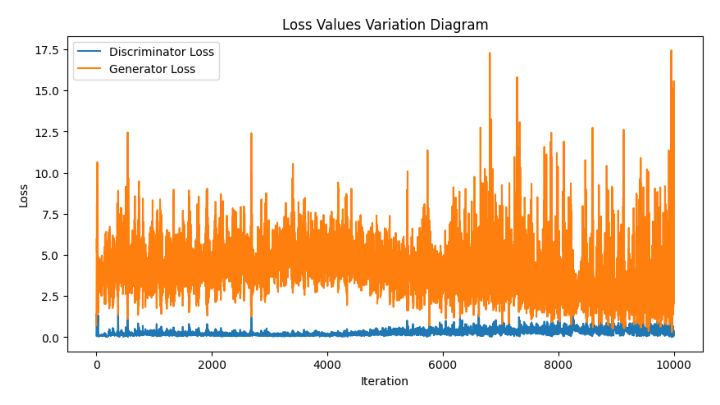

In [18]:
# YOUR CODE STARTS HERE

trainer.plot_losses_variation()

# YOUR CODE ENDS HERE

## **Visualization:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

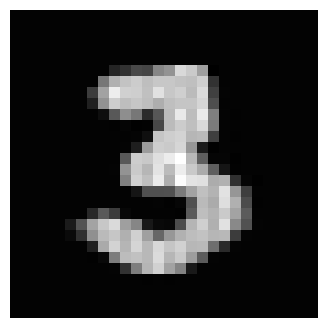

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

img_list = trainer.img_list
fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu().numpy()[0, 0], animated=True, cmap='gray')] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

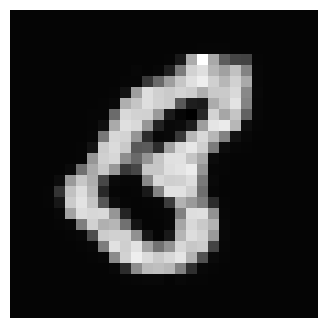

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

img_list = trainer.img_list
fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu().numpy()[0, 0], animated=True, cmap='gray')] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# FID score

In [12]:
!pip install --q pytorch-fid

In [24]:
model.eval()

# Generate fake images
num_samples = 10000
num_latents = 64
batch_size = 2048
output_directory = "generated_images"
os.makedirs(output_directory, exist_ok=True)

In [25]:
import os
import torch
from torchvision.utils import save_image

# Loop through batches
for batch_idx in range(num_samples // batch_size):
    # Generate random noise for the generator
    z_fake = torch.randn(batch_size, num_latents, device=device)

    # Generate fake images using the generator model
    with torch.no_grad():
        fake_images = model.g(z_fake).detach().cpu()

    # Save each generated image to the output directory
    for i in range(batch_size):
        # Construct the path for saving the image
        image_path = os.path.join(output_directory, f"generated_image_{batch_idx * batch_size + i + 1}.png")

        # Save the generated image
        save_image(fake_images[i], image_path)

print("Done")


Done


In [23]:
# Directory to save real images
mnist_directory = "mnist_images"
os.makedirs(mnist_directory, exist_ok=True)

# Load real images from the MNIST dataset
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10000,  # there are 10,000 images in the test set
    shuffle=True
)

# Get a batch of real images
real_images, _ = next(iter(mnist_loader))
real_images = real_images.to(device)

# Loop through the real images and save each one
for i in range(num_samples):
    # Construct the path for saving the real image
    image_path = os.path.join(mnist_directory, f"real_image_{i + 1}.png")

    # Save the real image
    save_image(real_images[i], image_path)

print("Done")

Done


In [22]:
from pytorch_fid.fid_score import calculate_fid_given_paths


# Paths to generated images and real images
path_to_generated_images = '/content/generated_images'
path_to_real_images = '/content/mnist_images'

# Calculate the FID score
fid_value = calculate_fid_given_paths([path_to_generated_images, path_to_real_images],
                                      batch_size=50,
                                      device='cuda',
                                      dims=2048)
print(f'FID score: {fid_value}')


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 240MB/s]
100%|██████████| 200/200 [00:37<00:00,  5.32it/s]


FID score: 45.657116388698


# WGAN

In [27]:
import torch
import torch.nn as nn

# Define custom layer for Reshape
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, num_channels):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 64 * 7 * 7),
            nn.BatchNorm1d(64 * 7 * 7),
            nn.ReLU(),
            Reshape(64, 7, 7),

            nn.PixelShuffle(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.PixelShuffle(2),

            nn.Conv2d(8, num_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.layers(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_channels):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            Reshape(64 * 7 * 7),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 1),
            Reshape()
        )

    def forward(self, x):
        return self.layers(x)


# Initialize the generator and discriminator
z_dim = 100  # replace with your desired latent space dimension
num_channels = 1
generator = Generator(z_dim, num_channels)
discriminator = Discriminator(num_channels)

# Print the model architectures
print("Generator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
print(discriminator)


Generator Architecture:
Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=3136, bias=True)
    (4): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Reshape()
    (7): PixelShuffle(upscale_factor=2)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): PixelShuffle(upscale_factor=2)
    (12): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Discriminator Architecture:
Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): 

Epoch 50/50: 100%|██████████| 938/938 [00:22<00:00, 42.29it/s]


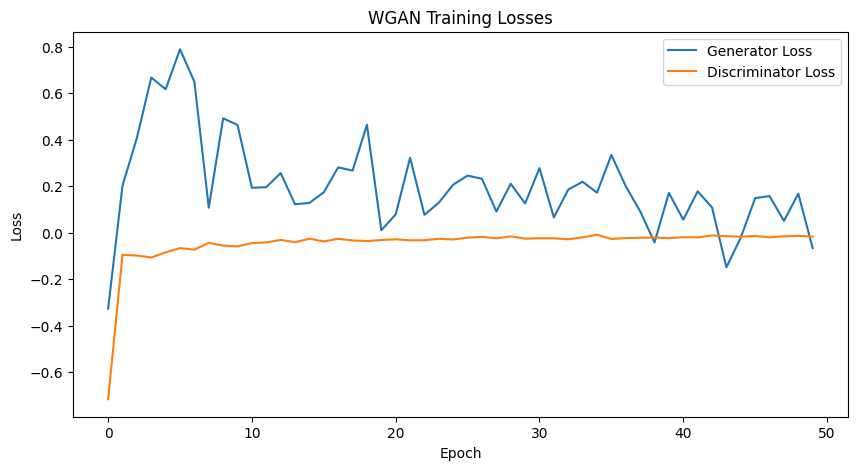

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters
batch_size = 64
z_dim = 100
lr = 0.00005
epochs = 50

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Initialize models and optimizers
generator = Generator(z_dim, num_channels)
discriminator = Discriminator(num_channels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

# Lists to store the losses
losses_G = []
losses_D = []

# WGAN training loop
for epoch in range(epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):

        # Training Discriminator
        real_images = real_images.to(device)
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)

        # Discriminator predictions
        real_preds = discriminator(real_images)
        fake_preds = discriminator(fake_images.detach())

        # WGAN loss
        loss_D = -torch.mean(real_preds) + torch.mean(fake_preds)

        # Update Discriminator
        loss_D.backward()
        optimizer_D.step()

        # Clip discriminator weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Training Generator
        optimizer_G.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)

        # Discriminator predictions on fake images
        fake_preds = discriminator(fake_images)

        # WGAN loss for the generator
        loss_G = -torch.mean(fake_preds)

        # Update Generator
        loss_G.backward()
        optimizer_G.step()

    # Save losses
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    # Print and save generated images (10x10 grid)
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_samples = generator(torch.randn(100, z_dim).to(device)).cpu()  # 10x10 grid, 100 samples
        torchvision.utils.save_image(fake_samples.view(100, 1, 28, 28), f"gan_generated_epoch_{epoch + 1}.png", normalize=True, nrow=10)


# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN Training Losses')
plt.show()


# method 2

In [ ]:
class WGAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()

    def loss_wasserstein_gp(self, x_real, *, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (batch_size, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): Wasserstein GAN discriminator loss
        - g_loss (torch.Tensor): Wasserstein GAN generator loss
        '''

        # Generate random noise vector
        batch_size = x_real.shape[0]   # 64
        z = torch.randn(batch_size, self.g.z_dim, device=device)

        # Generate fake images using the generator
        x_fake = self.g(z)

        # Compute discriminator outputs for real and fake images
        d_real = self.d(x_real)
        d_fake = self.d(x_fake)
        d_fake_clone =  self.d(x_fake.clone().detach())


        # Wasserstein GAN discriminator loss
        d_loss = d_fake_clone.mean() - d_real.mean()

        # Wasserstein GAN generator loss
        g_loss = -d_fake.mean()

        return d_loss, g_loss


In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=100,
                 out_dir=""
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents

        self.G_losses = []  # Store generator losses
        self.D_losses = []  # Store discriminator losses
        self.img_list = []  # Store generated images during training

        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            fake = ((generator(self.z_test) + 1) / 2.)
            self.img_list.append(fake)
            generator.train()
        vutils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step), nrow=10, padding=2, normalize=True)

    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))

    def gan_step(self, x_real, y_real):
        assert len(self.optimizers) == 2

        generator, discriminator = self.model.g, self.model.d
        g_optimizer, d_optimizer = self.optimizers

        # Compute discriminator and generator losses
        discriminator_loss, generator_loss = self.model.loss_wasserstein_gp(x_real, device=self.device)

        # Update generator
        g_optimizer.zero_grad()
        generator_loss.backward(retain_graph=True)
        g_optimizer.step()

        # Update discriminator
        d_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()

        # Clip discriminator weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Update the optimizers in the class
        self.optimizers = [g_optimizer, d_optimizer]

        # Append losses to the lists
        self.D_losses.append(discriminator_loss.item())
        self.G_losses.append(generator_loss.item())

        return {"discriminator_loss": discriminator_loss, "generator_loss": generator_loss}, None

    def train(self, train_loader, reinit=False):
        global_step = 0

        # train model from scratch
        if reinit:
            # OPTIONAL: Initialize your model if needed
            pass

        # train models for multiple epochs
        with tqdm(total=int(self.iter_max)) as pbar:
            # for epoch in range(self.iter_max):
            while global_step < self.iter_max:
                for batch_idx, (x, y) in enumerate(train_loader):
                    x_real = x.to(self.device)
                    y_real = y.to(self.device)

                    loss, summaries = self.gan_step(x_real, y_real)
                    global_step += 1
                    pbar.update(1)
                    self.checkpoint_and_log(global_step, loss, summaries)

                    if global_step >= self.iter_max:
                        break

    def plot_losses_variation(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.D_losses, label="Discriminator Loss")
        plt.plot(self.G_losses, label="Generator Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Loss Values Variation Diagram")
        plt.legend()
        plt.savefig("%s/loss_plot.png" % self.out_dir)
        plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
def build_model(device='cpu', num_latents=64):
    model = WGAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.RMSprop(model.g.parameters(), lr=0.00005)
    d_opt = torch.optim.RMSprop(model.d.parameters(), lr=0.00005)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./'
                  )

trainer.train(train_loader)

trainer.viz()

100%|██████████| 10000/10000 [04:16<00:00, 39.02it/s]


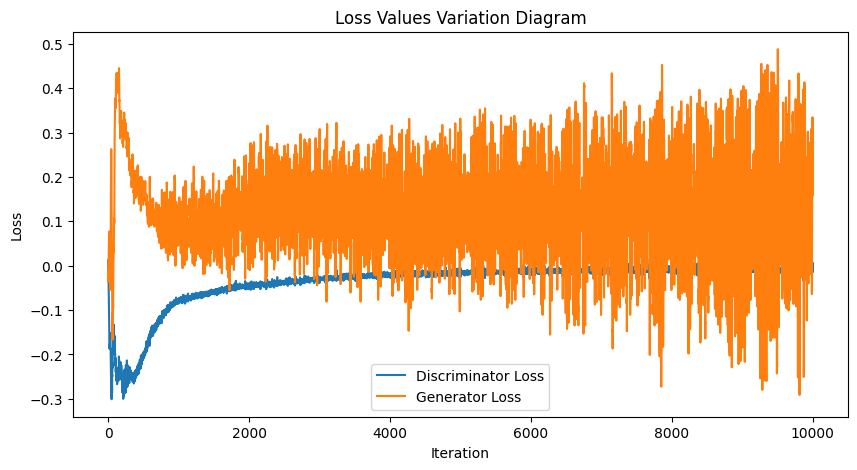

In [ ]:
trainer.plot_losses_variation()

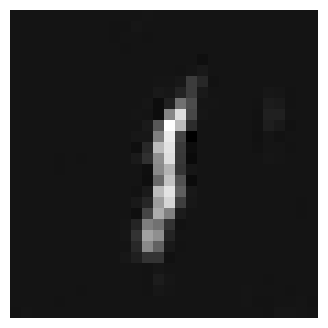

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

img_list = trainer.img_list
fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu().numpy()[2, 0], animated=True, cmap='gray')] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# FID-WGAN

In [31]:
!pip install --q pytorch-fid

In [30]:
model.eval()

# Generate fake images
num_samples = 10000
num_latents = 64
batch_size = 2048
output_directory = "generated_images_WGAN"
os.makedirs(output_directory, exist_ok=True)

In [31]:
for batch_idx in range(num_samples // batch_size):
    z_fake = torch.randn(batch_size, num_latents, device=device)

    with torch.no_grad():
        fake_images = model.g(z_fake).detach().cpu()

    for i in range(batch_size):

        image_path = os.path.join(output_directory, f"generated_image_{batch_idx + i + 1}.png")
        save_image(fake_images[i], image_path)

print("Done")

Done


In [32]:
#Real images
mnist_directory = "mnist_images_WGAN"
os.makedirs(mnist_directory, exist_ok=True)

mnist_loader = torch.utils.data.DataLoader(datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor()),
batch_size=10000, shuffle=True)

real_images, _ = next(iter(mnist_loader))
real_images = real_images.to(device)

for i in range(num_samples):
    image_path = os.path.join(mnist_directory, f"real_image_{i + 1}.png")
    save_image(real_images[i], image_path)

print("Done")

Done


In [33]:
from pytorch_fid.fid_score import calculate_fid_given_paths


# Paths to generated images and real images
path_to_generated_images = '/content/generated_images_WGAN'
path_to_real_images = '/content/mnist_images_WGAN'

# Calculate the FID score
fid_value = calculate_fid_given_paths([path_to_generated_images, path_to_real_images],
                                      batch_size=50,
                                      device='cuda',
                                      dims=2048)
print(f'FID score: {fid_value}')


100%|██████████| 200/200 [00:37<00:00,  5.29it/s]


FID score: 46.32213344221503
